In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
np.random.seed(1)

### 1. Load and prepare dataset

In [2]:
# Load training data
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

In [3]:
# Load test data
test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

In [4]:
# Check all the classes
classes = np.array(test_dataset["list_classes"][:])

In [5]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [6]:
# Reshape the train and test set labels
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

y = [1], it's a 'cat' picture.


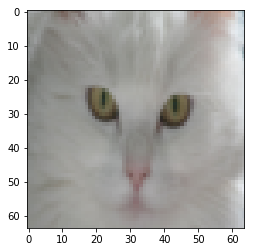

In [7]:
# Example of a picture
index = 50
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [8]:
# Checking the shape of datasets

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

print ("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [9]:
# reshape
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [10]:
# Standardizing dataset
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

### 2. Model 

In [11]:
# Sigmoid function
def sigmoid(Z):
    A = 1 / (1+np.exp(-Z))
    return A

In [12]:
# ReLU function
def relu(Z):
    A = np.maximum(0,Z)
    return A

In [13]:
# Initializing model parameters W and b
def init_params(layer_dims):
    np.random.seed(3)
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/ np.sqrt(layer_dims[l-1])
        params['b'+str(l)] = np.zeros((layer_dims[l], 1))
    
    return params

In [14]:
# Forward propagation step (for 1 layer)
def forward_prop_step(A_prev, W, b, activ_func):
    Z = np.dot(W, A_prev) + b
    
    if activ_func == 'relu':
        A = relu(Z)
    elif activ_func == 'sigmoid':
        A = sigmoid(Z)

    cache = (A_prev, W, b, Z)    
    return A, cache

In [15]:
# Forward propagation - full iteration (for 1 to L layers)
def forward_prop_model(X, params): 
    caches=[]
    L = len(params)//2
    A = X
    
    # Apply ReLU activaition function, while propagating forward over the layers from 1 to L-1
    for l in range (1,L):
        A_prev = A
        A, cache = forward_prop_step(A_prev, params['W'+str(l)], params['b'+str(l)], 'relu')
        caches.append(cache)
    
    # Apply Sigmoid activaition function, while propagating forward over the last layer (layer L)
    AL, cache = forward_prop_step(A, params['W'+str(L)], params['b'+str(L)], 'sigmoid')
    caches.append(cache)
    
    return AL, caches

In [16]:
# Cost function
def cost_func(A, Y):
    m = Y.shape[1]    
    cost = -1/m * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1-Y, np.log(1-A)))
    return cost

In [17]:
# Calculating dZ for backpropagation step for the layer with sigmoid
def sigmoid_backward(dA, Z):
    g_deriv = np.multiply (sigmoid(Z), (1-sigmoid(Z)))
    dZ = np.multiply (dA, g_deriv)
    return dZ

In [18]:
# Calculating dZ for backpropagation step for the layer with ReLU
def relu_backward(dA, Z):
    g_deriv = np.where(Z<0, 0, 1)    
    dZ = np.multiply(dA, g_deriv)
    return dZ

In [19]:
# Backpropagation step (for 1 layer)
def back_prop(dA, cache, activ_func):
    m = dA.shape[1]
    
    A_prev, W, b, Z = cache
    
    if activ_func == 'relu':
        dZ = relu_backward(dA, Z)
    elif activ_func == 'sigmoid':
        dZ = sigmoid_backward(dA, Z)

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dW, db, dA_prev

In [20]:
# Backpropagation - full iteration (for L to 1 layers)
def back_prop_model (AL, Y, caches):    # for whole NN (all layers) 
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Backpropagating over the last layer (layer L) with Sigmoid activaition function
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))        
    current_cache = caches[L-1]    
    grads['dW'+str(L)], grads['db'+str(L)], grads['dA'+str(L-1)] = back_prop(dAL, current_cache, 'sigmoid')    
    
    # Backpropagating over the layers from L-1 to 1 with ReLU activaition function
    for l in reversed(range(L-1)):  # from l=L-2 to l=0
        current_cache = caches[l]
        dA = grads['dA'+str(l+1)]
        grads['dW'+str(l+1)], grads['db'+str(l+1)], grads['dA'+str(l)] = back_prop(dA, current_cache, 'relu')
        
    return grads

In [21]:
# Updating parameters W and b
def update_params(params, grads, learning_rate):
    L = len(params)//2
    for l in range(L):
        params['W'+str(l+1)] = params['W'+str(l+1)] - learning_rate * grads['dW'+str(l+1)]
        params['b'+str(l+1)] = params['b'+str(l+1)] - learning_rate * grads['db'+str(l+1)]

    return params

In [22]:
# L-layers NN model
def model_L_Layers(X, Y, layer_dims, num_iter = 2500, learning_rate = 0.0075):

    parameters = init_params(layer_dims)
    
    for i in range(0, num_iter):
        # Forward propagation
        AL, caches = forward_prop_model (X, parameters)
                
        #Cost-function
        cost = cost_func(AL, Y)
        
        # Backpropagation
        grads = back_prop_model (AL, Y, caches)
        
        # Updating parameters W and b
        parameters = update_params(parameters, grads, learning_rate)     

        # print Cost-function on every 100-th iteration
        if i%100 == 0:    
            print ("Cost after iteration %i: %f" %(i, cost))    
            
    return parameters

In [23]:
# Building the model. As a result - get its parameters W and b.

# Set the width and depth of the model 
n_x = train_set_x.shape[0]   #  input layer (layer 0)
layer_dims = [n_x, 20, 7, 5, 1] #  4-layer model

parameters = model_L_Layers(train_set_x, train_set_y, layer_dims, num_iter = 3000, learning_rate = 0.0075)

Cost after iteration 0: 0.715732
Cost after iteration 100: 0.674738
Cost after iteration 200: 0.660337
Cost after iteration 300: 0.646289
Cost after iteration 400: 0.629813
Cost after iteration 500: 0.606006
Cost after iteration 600: 0.569004
Cost after iteration 700: 0.519797
Cost after iteration 800: 0.464157
Cost after iteration 900: 0.408420
Cost after iteration 1000: 0.373155
Cost after iteration 1100: 0.305724
Cost after iteration 1200: 0.268102
Cost after iteration 1300: 0.238725
Cost after iteration 1400: 0.206323
Cost after iteration 1500: 0.179439
Cost after iteration 1600: 0.157987
Cost after iteration 1700: 0.142404
Cost after iteration 1800: 0.128652
Cost after iteration 1900: 0.112443
Cost after iteration 2000: 0.085056
Cost after iteration 2100: 0.057584
Cost after iteration 2200: 0.044568
Cost after iteration 2300: 0.038083
Cost after iteration 2400: 0.034411
Cost after iteration 2500: 0.031732
Cost after iteration 2600: 0.029782
Cost after iteration 2700: 0.028223
Cost

### 3. Prediction

In [24]:
# Predicting Y, having W and b parameters
def predict_Y (X, params):
    m = X.shape[1]
    Y_predict = np.zeros((1, m))

    AL, caches = forward_prop_model(X, params)

    for i in range(m):
        # Convert probabilities A[0,i] to actual predictions p[0,i]    
        if AL[0,i] > 0.5:
            Y_predict[0,i] = 1
    return Y_predict

In [25]:
# Predicting Y on train and test datasets
Y_train_prediction = predict_Y (train_set_x, parameters)
Y_test_prediction = predict_Y (test_set_x, parameters)
    
# Print train and test accuracy
print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_train_prediction - train_set_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_test_prediction - test_set_y)) * 100))

train accuracy: 99.52153110047847 %
test accuracy: 78.0 %
